In [ ]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

In [ ]:
!pip install pyTsetlinMachineParallel
from pyTsetlinMachineParallel.tm import MultiClassTsetlinMachine
!export OMP_NUM_THREADS=10

  Preparing metadata (setup.py) ... done
  Created wheel for pyTsetlinMachineParallel: filename=pyTsetlinMachineParallel-0.2.1-cp311-cp311-linux_x86_64.whl size=41743 sha256=f0ebb0c7f43e17934ae3872ef57a72fc3bfa0ea559d3bde34a4b7256a71f4b99
  Stored in directory: /root/.cache/pip/wheels/51/01/e6/5395e43582a8e9b52668b055885ac72d6ff913a4d7e689ee9e
Successfully built pyTsetlinMachineParallel


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# X_train = np.load('/content/drive/MyDrive/traffic-sign/X_train.rgb.npy')
# y_train = np.load('/content/drive/MyDrive/traffic-sign/Y_train.rgb.npy')
# X_test = np.load('/content/drive/MyDrive/traffic-sign/X_test.rgb.npy')
# y_test = np.load('/content/drive/MyDrive/traffic-sign/Y_test.rgb.npy')

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

print("Load Data Successfully")

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Val: features {np.array(X_val).shape}, labels {np.array(y_val).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Load Data Successfully

Dataset Shapes:
Train: features (40000, 32, 32, 3), labels (40000,)
Val: features (10000, 32, 32, 3), labels (10000,)
Test: features (10000, 32, 32, 3), labels (10000,)


(40000, 32, 32, 3) (40000,)


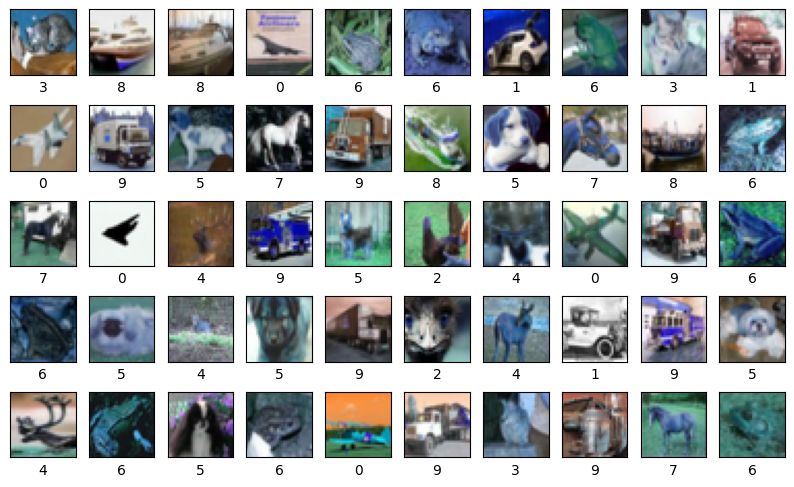

In [ ]:
print(X_train.shape, y_train.shape)

plt.figure(figsize=(10,6))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i][:,:,::-1])
    plt.xlabel(y_test[i])

In [ ]:
# ------------------------------------------------
# 6. Use CNN for Feature Extraction and Train Tsetlin Machine on Binarized Features
# ------------------------------------------------
# Import necessary libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
#from tmu.models.classification.vanilla_classifier import TMClassifier
import numpy as np

# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0


# Define a simple CNN architecture for feature extraction
input_layer = Input(shape=(32, 32, 3))  # Input shape matches traffic sign images (32x32x3)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
feature_layer = Dense(1024, activation='sigmoid')(x)  # Feature layer with 256 units
output_layer = Dense(y_test.max() + 1, activation='softmax')(feature_layer)  # output classes for traffic signs

# Create and compile the CNN model
cnn_model = Model(inputs=input_layer, outputs=output_layer)

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #'categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN on the original images
print("\nTraining CNN for feature extraction...")
his = cnn_model.fit(X_train_norm, y_train,
              validation_data=(X_val_norm, y_val),
              #validation_split=0.2,
              epochs=50,
              batch_size=128,
              verbose=1)

#his = cnn_model.fit(X_train, y_train_cat, batch_size=32, epochs=10, validation_split=0.2, verbose=1)

scores = cnn_model.evaluate(X_train, y_train, verbose=2)
print("Train accuracy: %.2f%%" % (scores[1]*100))
scores = cnn_model.evaluate(X_val, y_val, verbose=2)
print("Test accuracy: %.2f%%" % (scores[1]*100))
scores = cnn_model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy: %.2f%%" % (scores[1]*100))


Training CNN for feature extraction...
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3502 - loss: 1.8192 - val_accuracy: 0.5564 - val_loss: 1.2473
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5794 - loss: 1.1978 - val_accuracy: 0.6164 - val_loss: 1.0869
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6390 - loss: 1.0298 - val_accuracy: 0.6484 - val_loss: 0.9930
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6723 - loss: 0.9285 - val_accuracy: 0.6695 - val_loss: 0.9488
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7091 - loss: 0.8338 - val_accuracy: 0.6727 - val_loss: 0.9343
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7363 - loss: 0.7476 - val_accuracy: 0.6942 - val_loss: 0.8802
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7574 - loss: 0.6843 - val_accuracy: 0.6896 - val_loss: 0.9020
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy:

In [ ]:
print(cnn_model.summary())      # вывод структуры НС в консоль

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,674,912 (48.35 MB)

 Trainable params: 4,224,970 (16.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,449,942 (32.23 MB)

None


In [ ]:
# Create a feature extractor model (output from the Dense 256 layer)
feature_extractor = Model(inputs=cnn_model.input, outputs=feature_layer) # outputs=feature_layer

# Extract features for train, validation, and test sets
X_train_features = feature_extractor.predict(X_train_norm)
X_val_features = feature_extractor.predict(X_val_norm)
X_test_features = feature_extractor.predict(X_test_norm)

# Binarize the features using the mean as a threshold
threshold = X_train_features.mean()
X_train_bin = (X_train_features > threshold).astype(np.uint32)
X_val_bin = (X_val_features > threshold).astype(np.uint32)
X_test_bin = (X_test_features > threshold).astype(np.uint32)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
print(X_train_features.min(), X_train_bin.min())
print(X_train_bin[0])

0.0 0
[1 0 0 ... 0 1 0]


In [ ]:
# # Ensure labels are in the correct format for Tsetlin Machine
# y_train = y_train.astype(np.uint32)
# #y_valid = y_valid.astype(np.uint32)
# y_test = y_test.astype(np.uint32)

# # Initialize Tsetlin Machine with tuned hyperparameters
# tm = TMClassifier(
#     number_of_clauses=5000,  # Increased to capture more patterns
#     T=50,                   # Higher threshold for clause complexity
#     s=10.0,                 # Increased specificity
#     clause_drop_p=0.1       # Dropout for regularization
# )
C = 100
T = 7
s = 6
tm = MultiClassTsetlinMachine(C, T, s)
tm.fit(X_train_bin, y_train, epochs=0, incremental=True)

# Train Tsetlin Machine with early stopping
epochs = 100
best_val_acc = 0
patience = 20
no_improvement_count = 0

print("\nTraining Tsetlin Machine on CNN-extracted features...")
for epoch in range(epochs):
    tm.fit(X_train_bin, y_train, epochs=1, incremental=True)
    train_pred = tm.predict(X_train_bin)
    val_pred = tm.predict(X_val_bin)
    train_acc = np.mean(train_pred == y_train) * 100
    val_acc = np.mean(val_pred == y_val) * 100
    print(f"Epoch {epoch+1:2d}/{epochs} - Train Accuracy: {train_acc:5.2f}% | Validation Accuracy: {val_acc:5.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience and val_acc > 80:
            print("Early stopping triggered: Validation accuracy exceeds 80% with no improvement.")
            break

# Evaluate on the test set
test_pred = tm.predict(X_test_bin)
test_acc = np.mean(test_pred == y_test) * 100
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")


Training Tsetlin Machine on CNN-extracted features...
Epoch  1/100 - Train Accuracy: 91.19% | Validation Accuracy: 66.73%
Epoch  2/100 - Train Accuracy: 94.92% | Validation Accuracy: 68.02%
Epoch  3/100 - Train Accuracy: 95.94% | Validation Accuracy: 68.79%
Epoch  4/100 - Train Accuracy: 96.23% | Validation Accuracy: 68.87%
Epoch  5/100 - Train Accuracy: 97.19% | Validation Accuracy: 69.11%
Epoch  6/100 - Train Accuracy: 97.54% | Validation Accuracy: 69.67%
Epoch  7/100 - Train Accuracy: 97.84% | Validation Accuracy: 69.32%
Epoch  8/100 - Train Accuracy: 98.04% | Validation Accuracy: 70.14%
Epoch  9/100 - Train Accuracy: 98.15% | Validation Accuracy: 69.93%
Epoch 10/100 - Train Accuracy: 98.16% | Validation Accuracy: 70.03%
Epoch 11/100 - Train Accuracy: 98.14% | Validation Accuracy: 69.70%
Epoch 12/100 - Train Accuracy: 98.54% | Validation Accuracy: 69.64%
Epoch 13/100 - Train Accuracy: 98.45% | Validation Accuracy: 69.75%
Epoch 14/100 - Train Accuracy: 98.53% | Validation Accuracy: 

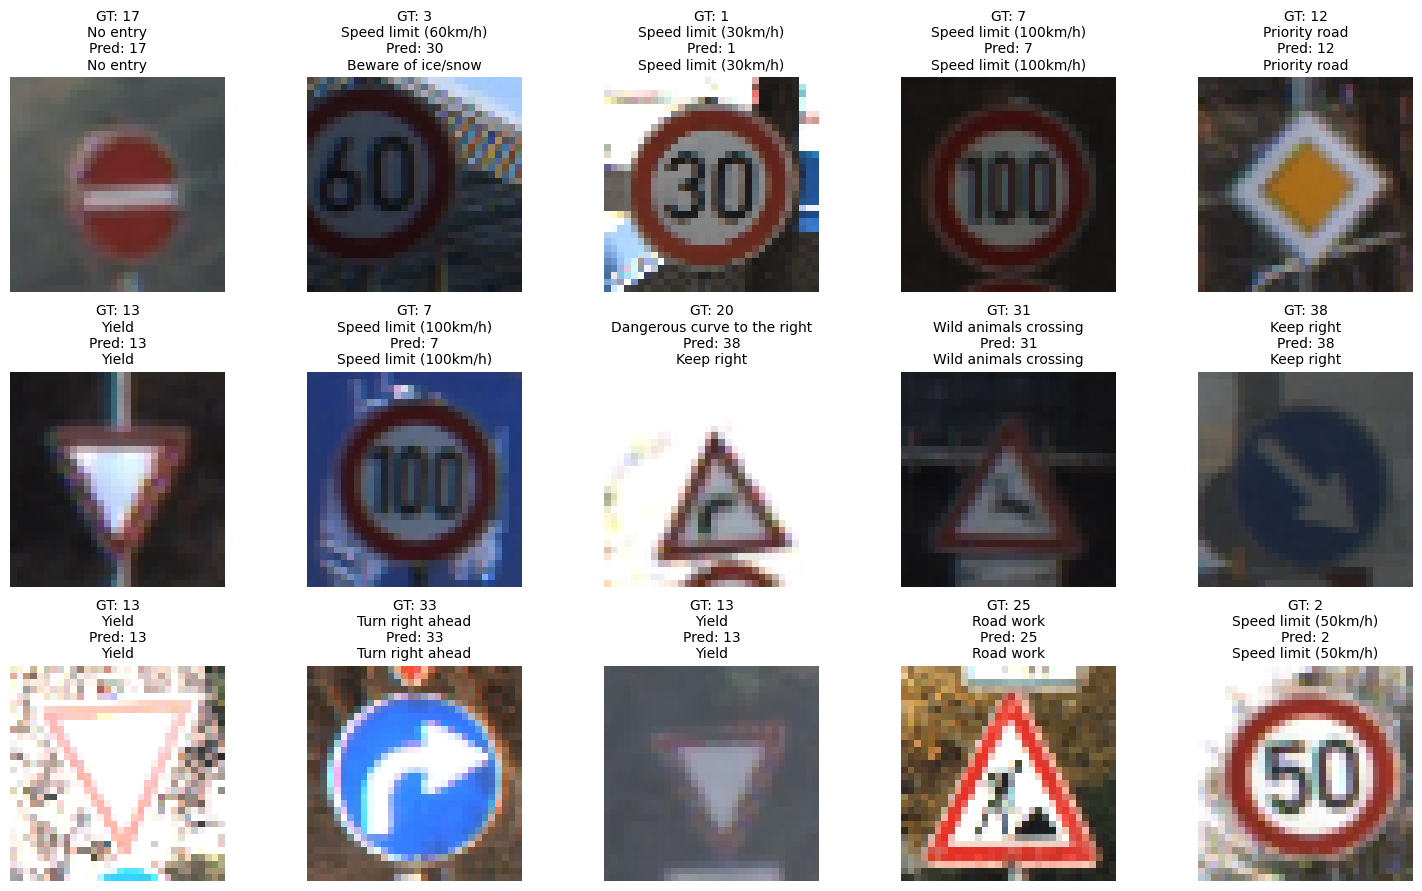

In [ ]:
# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label = test_pred[idx]

    # Retrieve the actual sign names using the mapping
    true_sign_name = sign_mapping.get(true_label, 'Unknown')
    pred_sign_name = sign_mapping.get(pred_label, 'Unknown')

    # Display the image
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)

    ax.set_title(f"GT: {true_label}\n{true_sign_name}\nPred: {pred_label}\n{pred_sign_name}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()